# Image acquisation

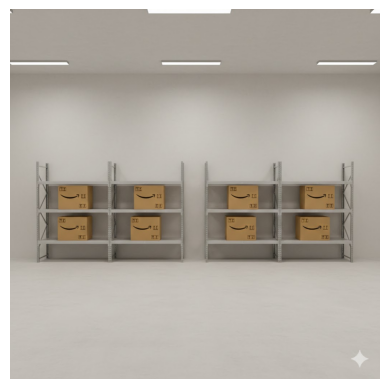

In [32]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("retail.jpg")

if img is None:
    raise IOError("Image not found")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# preprocessing

In [33]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
equalized = cv2.equalizeHist(blur)


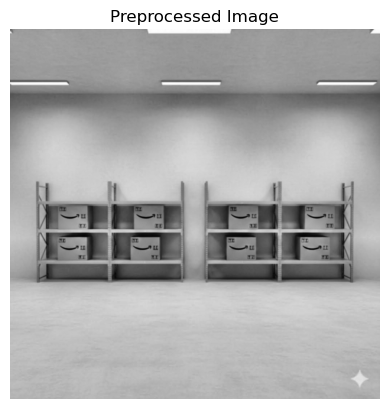

In [34]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

clahe = cv2.createCLAHE(2.0, (8,8))
preprocessed = clahe.apply(blur)

plt.imshow(preprocessed, cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()


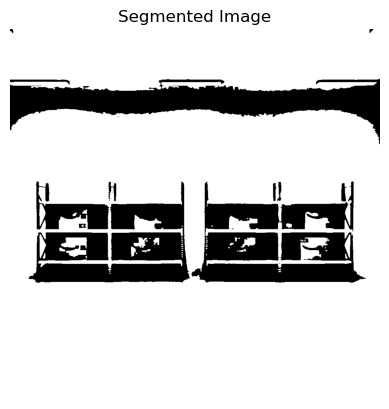

In [35]:
_, binary = cv2.threshold(
    preprocessed, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

plt.imshow(binary, cmap="gray")
plt.title("Segmented Image")
plt.axis("off")
plt.show()


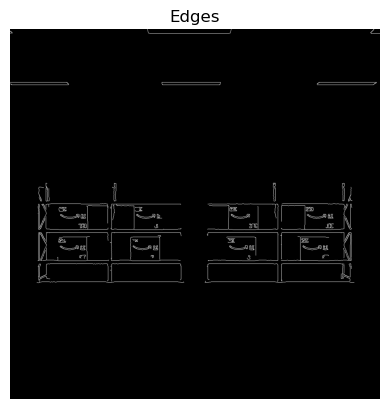

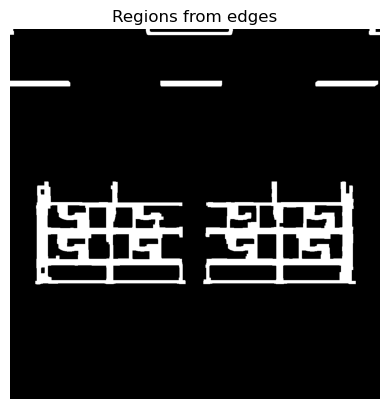

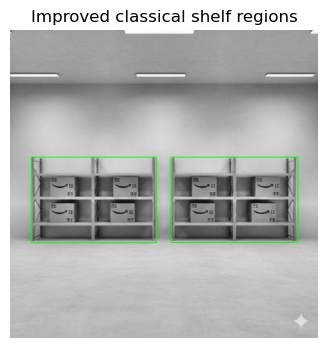

True

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# 1. Canny (slightly smoothed)
# ------------------------------------
 
edges = cv2.Canny(blur, 60, 160)

plt.imshow(edges, cmap="gray")
plt.title("Edges")
plt.axis("off")
plt.show()

# ------------------------------------
# 2. Close gaps between edges
# ------------------------------------
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close, iterations=2)

# ------------------------------------
# 3. Thicken to form regions
# ------------------------------------
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
regions = cv2.dilate(closed, kernel_dilate, iterations=2)

plt.imshow(regions, cmap="gray")
plt.title("Regions from edges")
plt.axis("off")
plt.show()

# ------------------------------------
# 4. Contours on regions
# ------------------------------------
contours, _ = cv2.findContours(
    regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

output = cv2.cvtColor(preprocessed, cv2.COLOR_GRAY2BGR)

H, W = preprocessed.shape

for cnt in contours:

    x, y, w, h = cv2.boundingRect(cnt)

    area   = w * h
    aspect = w / float(h)

    # -------------------------
    # smaller minimum area
    # -------------------------
    if area < 1800:
        continue

    # -------------------------
    # keep shelves (lower the top cut)
    # -------------------------
    if y < 0.20 * H:
        continue

    # -------------------------
    # allow shelves that touch floor
    # -------------------------
    if y + h > 0.98 * H:
        continue

    # -------------------------
    # remove very thin noise
    # -------------------------
    if h < 35 or w < 35:
        continue

    # -------------------------
    # remove ceiling lamps
    # -------------------------
    if aspect > 8.0 and h < 70:
        continue

    # -------------------------
    # allow near-square shelves
    # -------------------------
    if aspect < 0.45:
        continue

    cv2.rectangle(output, (x, y), (x + w, y + h), (0,255,0), 2)




plt.figure(figsize=(6,4))
plt.imshow(output, cmap="gray")
plt.title("Improved classical shelf regions")
plt.axis("off")
plt.show()

cv2.imwrite("segmented_canny_improved.jpg", output)


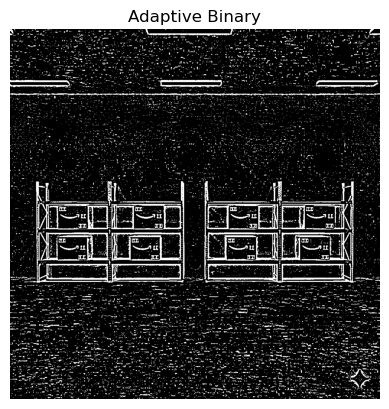

In [40]:

binary = cv2.adaptiveThreshold(
    preprocessed, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

plt.imshow(binary, cmap="gray")
plt.title("Adaptive Binary")
plt.axis("off")
plt.show()


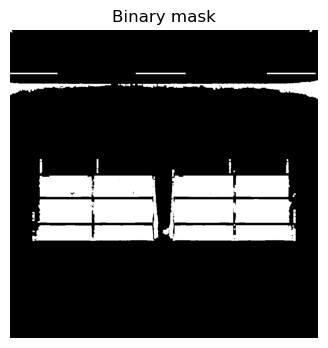

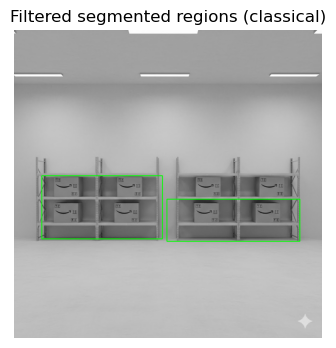

True

In [42]:
# -----------------------------------
# 1. Otsu threshold
# -----------------------------------
_, thresh = cv2.threshold(
    img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# -----------------------------------
# 2. Invert (important for this scene)
# shelves / boxes are darker
# -----------------------------------
thresh = cv2.bitwise_not(thresh)

# -----------------------------------
# 3. Remove noise
# -----------------------------------
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

plt.figure(figsize=(5,4))
plt.imshow(thresh, cmap="gray")
plt.title("Binary mask")
plt.axis("off")
plt.show()

# -----------------------------------
# 4. Contours
# -----------------------------------
contours, _ = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# -----------------------------------
# 5. Region filtering (VERY IMPORTANT)
# -----------------------------------
for cnt in contours:

    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect = w / float(h)

    # remove tiny blobs
    if area < 800:
        continue

    # remove ceiling / wall background
    if y < 0.25 * H:
        continue

    # remove floor region
    if y + h > 0.95 * H:
        continue

    # remove full wall merges
    if w > 0.9 * W:
        continue

    # remove very thin strips
    if h < 20 or w < 20:
        continue

    # shelves / box stacks are roughly rectangular
    if aspect < 0.4 or aspect > 5.0:
        continue

    cv2.rectangle(output, (x, y), (x + w, y + h), (0,255,0), 2)


# -----------------------------------
# 6. Show result
# -----------------------------------
plt.figure(figsize=(6,4))
plt.imshow(output, cmap="gray")
plt.title("Filtered segmented regions (classical)")
plt.axis("off")
plt.show()

cv2.imwrite("segmented_filtered.jpg", output)

# feature extraction

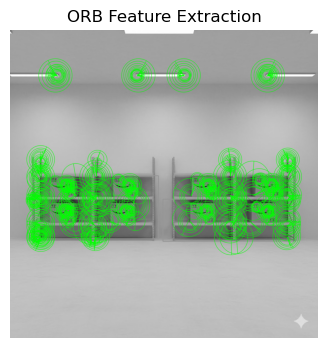

In [43]:
import cv2
import matplotlib.pyplot as plt

# Load segmented image
img = cv2.imread('segmented_filtered.jpg', cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found: segmented.jpg")

# ORB feature detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(img, None)

if descriptors is None:
    print("⚠️ No features detected")

# Draw keypoints
output = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    color=(0,255,0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Display safely (NO GUI BLOCKING)
plt.figure(figsize=(6,4))
plt.imshow(output, cmap="gray")
plt.title("ORB Feature Extraction")
plt.axis("off")
plt.show()


✅ Keypoints detected: 500


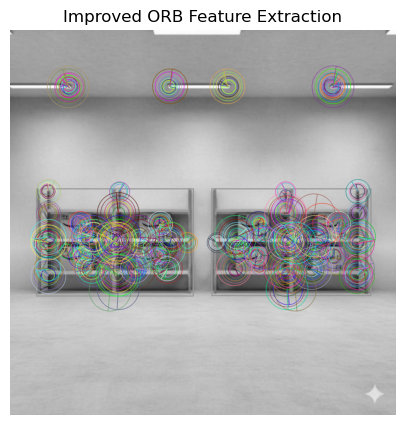

True

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Load image safely
# -----------------------------
img = cv2.imread("segmented_canny_improved.jpg", cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found: segmented.jpg")

# -----------------------------
# Improve image slightly for ORB
# (helps reduce noise features)
# -----------------------------
blur = cv2.GaussianBlur(img, (5, 5), 0)

# -----------------------------
# ORB with controlled parameters
# -----------------------------
orb = cv2.ORB_create(
    nfeatures=500,        # ↓ fewer, meaningful keypoints
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    fastThreshold=20      # ↑ more selective FAST corners
)

# Detect keypoints & descriptors
keypoints, descriptors = orb.detectAndCompute(blur, None)

if descriptors is None:
    print("⚠️ No features detected")
else:
    print(f"✅ Keypoints detected: {len(keypoints)}")

# -----------------------------
# Draw keypoints (cleaner style)
# -----------------------------
output = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# -----------------------------
# Display safely
# -----------------------------
plt.figure(figsize=(7,5))
plt.imshow(output, cmap="gray")
plt.title("Improved ORB Feature Extraction")
plt.axis("off")
plt.show()

# Optional: save output
cv2.imwrite("orb_features_improved.jpg", output)


# feature matching

Good matches: 500


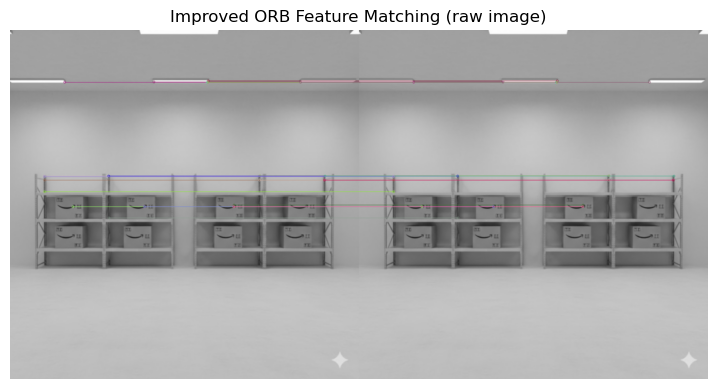

In [53]:
import cv2
import matplotlib.pyplot as plt

# --------------------------------------------------
# Load RAW images (not segmented / drawn images)
# --------------------------------------------------
img1 = cv2.imread("retail.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("retail.jpg", cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    raise IOError("Images not found")

# --------------------------------------------------
# Slight blur for stability
# --------------------------------------------------
img1 = cv2.GaussianBlur(img1, (5,5), 0)
img2 = cv2.GaussianBlur(img2, (5,5), 0)

# --------------------------------------------------
# ORB detector (controlled)
# --------------------------------------------------
orb = cv2.ORB_create(nfeatures=500)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

if des1 is None or des2 is None:
    raise ValueError("Descriptors missing")

# --------------------------------------------------
# Brute force + KNN
# --------------------------------------------------
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# --------------------------------------------------
# Lowe ratio test
# --------------------------------------------------
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

print("Good matches:", len(good))

# --------------------------------------------------
# Draw matches
# --------------------------------------------------
output = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    good[:20],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(9,5))
plt.imshow(output, cmap="gray")
plt.title("Improved ORB Feature Matching (raw image)")
plt.axis("off")
plt.show()


✅ Good matches found: 500


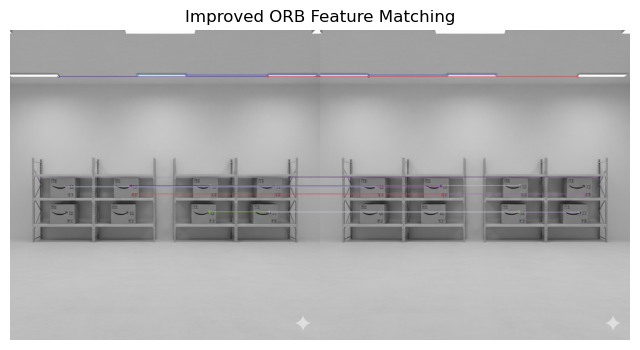

True

In [54]:
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# Load images safely
img1 = cv2.imread("retail.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("retail.jpg", cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    raise IOError("One or both images not found")

# -----------------------------
# ORB feature detector (controlled)
# -----------------------------
orb = cv2.ORB_create(nfeatures=500)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

if des1 is None or des2 is None:
    raise ValueError("Descriptors missing in one of the images")

# -----------------------------
# Brute Force Matcher + KNN
# -----------------------------
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# -----------------------------
# Lowe's Ratio Test (CRITICAL)
# -----------------------------
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"✅ Good matches found: {len(good_matches)}")

# -----------------------------
# Draw matches
# -----------------------------
matched_img = cv2.drawMatches(
    img1, kp1,
    img2, kp2,
    good_matches[:15],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# -----------------------------
# Display safely (NO GUI BLOCK)
# -----------------------------
plt.figure(figsize=(8,5))
plt.imshow(matched_img, cmap="gray")
plt.title("Improved ORB Feature Matching")
plt.axis("off")
plt.show()

# Optional: save output
cv2.imwrite("feature_matching_improved.jpg", matched_img)


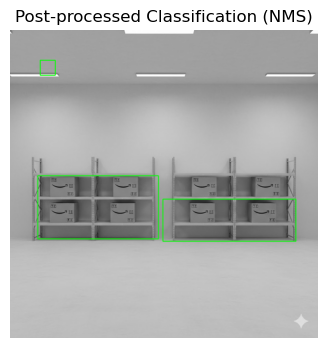

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('segmented_filtered.jpg')

if img is None:
    raise IOError("Image not found: segmented.jpg")

# Example detections [x, y, w, h, confidence]
detections = np.array([
    [100, 100, 50, 50, 0.9],
    [105, 105, 50, 50, 0.8]
])

boxes = detections[:, :4].tolist()
scores = detections[:, 4].tolist()

indices = cv2.dnn.NMSBoxes(boxes, scores, 0.5, 0.4)

# Draw final boxes
if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = map(int, boxes[i])
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)

# Display safely
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Post-processed Classification (NMS)")
plt.axis("off")
plt.show()
